Kristen Swerzenski

DSC 540

2 March 2024

## Project Milesone 5: Merging, Storing, and Visualizing the Data

In [1]:
# Importing necessary packages
import sqlite3
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

# Removing max column restraints for better visibility
pd.set_option('display.max_columns', None)

### Creating an SQLite Database and Adding in Each Data Source as Separate Tables

Now that I have all 3 of my cleaned and transformed data sets from different sources, I am going to insert each one into an SQL database as a table. Because there are three tables each with numerous columns, I am going to attempt to write a function that I can loop through each .csv file to build the SQLite table and insert each data set's data into it's respective table:

In [59]:
# Creating and connecting to an SQLite database
conn = sqlite3.connect('movies.db')
cur = conn.cursor()

try:
    # Defining a function that contains a query to create a table
    def create_table(table_name, column_names):
        # Making an SQL query to build a table
        columns = ', '.join([f'{name} TEXT' for name in column_names])
        query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
        cur.execute(query)

    # Defining a function to insert data from .csv files into an SQLite table
    def insert_data(table_name, csv_file):
        # Opening and reading the .csv file
        with open(csv_file, 'r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            # Skipping the header row
            next(csv_reader)
            for row in csv_reader:
                # Creating placeholders for each value in the row
                placeholders = ', '.join(['?' for _ in row])
                # Creating an INSERT query to insert data and executing query
                query = f'INSERT INTO {table_name} VALUES ({placeholders})'
                cur.execute(query, row)
    # Committing changes to database
    conn.commit()

    # Making lilsts of the file paths and corresponding table names to pass into the create_table and insert_data functions
    csv_files = ['flatfiledata_streaming.csv', 'webdata_boxoffice.csv', 'apidata_tmdb.csv']
    table_names = ['streaming_data', 'boxoffice_data', 'movie_data']

    # Iterating through the list of csv files to create three tables and insert data from the .csv files into them
    for table_name, csv_file in zip(table_names, csv_files):
        # Opening and reading .csv files
        with open(csv_file, 'r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            # Reading header row of .csv file
            headers = next(csv_reader)
            # Creating tables
            create_table(table_name, headers)
            # Inserting data
            insert_data(table_name, csv_file)

# Error handling to catch any exceptions during execution
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Closing the connection to the database
    conn.close()

Now that I built the tables, I want to make sure that the queries actually worked and the database was built correctly. I am going to pull record counts from each table and compare it against the number of records in the .csv files:

In [87]:
# Connecting to database
conn = sqlite3.connect('movies.db')
cur = conn.cursor()


# Check record counts
for table_name in table_names:
    # Query to get count of rows in the table
    cur.execute(f'SELECT COUNT(*) FROM {table_name}')
    # Fetching the count
    count_db = cur.fetchone()[0]
    # Finding the corresponding .csv index for the table
    csv_index = table_names.index(table_name)  
    with open(csv_files[csv_index], 'r', encoding='utf-8') as file:
        # Getting record count and subtracting one to account for header row
        count_csv = sum(1 for _ in file) - 1
    # Printing results
    print(f'Records in {table_name} table (DB): {count_db}')
    print(f'Records in {csv_files[csv_index]} file: {count_csv}')
    print('------------------------------------')

conn.close()

Records in streaming_data table (DB): 6153
Records in flatfiledata_streaming.csv file: 6155
------------------------------------
Records in boxoffice_data table (DB): 690
Records in webdata_boxoffice.csv file: 690
------------------------------------
Records in movie_data table (DB): 260
Records in apidata_tmdb.csv file: 260
------------------------------------


The record counts of my database tables and .csv files seem to match. There is a slight discrepancy in streaming_data in that the .csv is showing two extra rows, however I double checked my .csv and there are only 6153 so the cound is picking up some empty rows. The data has been added into tables in the database and is now ready to be joined together.

### Creating Joined Table of Data

The join I will be using in this project is an inner join, in that I want to create a table where I can combine data from across all tables along the key title and disclude any data that does not contain the common keys. 

In [63]:
# Connecting to the database
conn = sqlite3.connect('movies.db')
cur = conn.cursor()

# Try block for error handling
try:
    # Creating a new table to store joined results and querying the database to perform an inner join on my 3 tables
    cur.execute('''
    CREATE TABLE IF NOT EXISTS joined_table_inner AS
    SELECT s.*, b.*, m.*
    FROM streaming_data AS s
    JOIN boxoffice_data AS b ON s.title = b.title
    JOIN movie_data AS m ON s.title = m.title;
    ''')

    # Committing the transaction
    conn.commit()
    
    # Printing a message so I know the tables was created successfully
    print("Joined table created successfully.")

# Handlinlg errors
except Exception as e:
    print(f"An error occurred: {e}")

# Closing the connection
finally:
    conn.close()

Joined table created successfully.


It looks like the joined table was successfully created, but now I want to just check to make sure the data was combined correctly. I am going to write a query requesting the first 20 rows of data just to make sure everything is there.

In [64]:
# Connecting to the database
conn = sqlite3.connect('movies.db')
cur = conn.cursor()

# Executing a SELECt query to pull the first 20 records from the joined table
cur.execute('SELECT * FROM joined_table_inner LIMIT 20')

# Fetching the query results
results = cur.fetchall()

# Printing the fetched rows for inspection
for row in results:
    print(row)

# Closing the connection
conn.close()

('s7733', 'Movie', 'Peter Rabbit', 'Will Gluck', 'James Corden, Domhnall Gleeson, Rose Byrne, Margot Robbie, Daisy Ridley, Elizabeth Debicki, Vauxhall Jermaine, Marianne Jean-Baptiste, Sia, Colin Moody', 'United States, Australia', '2018-08-18', '2018', 'PG', '95', 'Children & Family Movies, Comedies', "In this mix of live action and CGI, rascally Peter Rabbit faces a tough new foe in his ongoing battle for the veggies in Mr. McGregor's garden.", 'Netflix', '29', '27', 'Peter Rabbit', '2/9/2018', '6/14/2018', '$115,253,424 ', '$115,253,424 ', '$25,010,928 ', '21.70%', '3725', '3725', 'Sony Pictures Releasing', 'FALSE', 'FALSE', 'FALSE', 'FALSE', '/1wj8H9gdtkb98Tl3zu0hrHfW0qw.jpg', '381719', 'en', 'Peter Rabbit', "Peter Rabbit's feud with Mr. McGregor escalates to greater heights than ever before as they rival for the affections of the warm-hearted animal lover who lives next door.", '20.623', '/lugOvdaNpbVGQK9TyMRDiUbLtY6.jpg', '2/7/2018', 'Peter Rabbit', 'FALSE', '6.7', '1684', 'Peter

Now that I have my tables and my joined table in my database, it is time to make some visualizations to explore my data some more.

### Visualization 1: Distribution of Movie Genres

The first visualization I am going to make is to inspect the distribution of of film genres in my joined table. To practice some more SQL I am going to write a query to pull counts for each of the generes, store the genres and counts in lists, and plot the lists of genres and their respective counts.

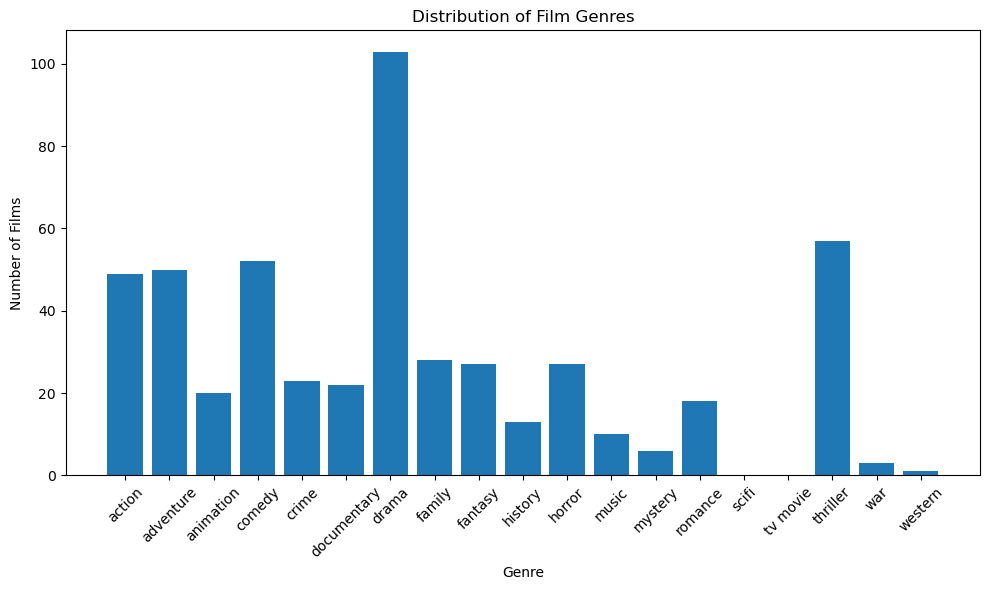

In [66]:
# Connecting to the database
conn = sqlite3.connect('movies.db')
cur = conn.cursor()

# Executing a query to pull counts from each genre using the dummy genre columns
cur.execute("""
SELECT
    SUM(genre_Action) AS action_count,
    SUM(genre_Adventure) as adventure_count,
    SUM(genre_Animation) AS animation_count,
    SUM(genre_Comedy) AS comedy_count,
    SUM(genre_Crime) AS crime_count,
    SUM(genre_Documentary) AS documentary_count,
    SUM(genre_Drama) AS drama_count,
    SUM(genre_Family) AS family_count,
    SUM(genre_Fantasy) AS fantasy_count,
    SUM(genre_History) AS history_count,
    SUM(genre_Horror) AS horror_count,
    SUM(genre_Music) AS music_count,
    SUM(genre_Mystery) AS mystery_count,
    SUM(genre_Romance) AS romance_count,
    SUM('genre_Science Fiction') AS scifi_count,
    SUM('genre_TV Movie') AS tvmovie_count,
    SUM(genre_Thriller) AS thriller_count,
    SUM(genre_War) AS war_count,
    SUM(genre_Western) AS western_count
FROM joined_table_inner
""")

# Fetching the results
genre_counts = cur.fetchone()

# Creating a list of genres
genres = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama',
          'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
          'scifi', 'tv movie', 'thriller', 'war', 'western']
# Creating a list of the corresponding genre counts
counts = [genre_counts[i] for i in range(len(genre_counts))]

# Plotting a bar chart of the counts per genre
plt.figure(figsize=(10,6))
plt.bar(genres, counts)
plt.xlabel("Genre")
plt.ylabel("Number of Films")
plt.title("Distribution of Film Genres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Closing the connection to the database
conn.close()

It seems like there were a large number of drama genre movies that were high up in box office earnings from 2018-2021 (since most of the films represented in ym joined database were the highest grossing films in each year). Other popular genres were thriller, comedy, action, and adventure. It could be interesting to dive further into the total amount of money each genre grossed.

### Visualization 2: Budget vs. Revenue

For my next visualization, I want to see if there is any correlation in the budget of a film and the amount of revenue it brought in (ie, did films that cost more money to make end up earning more money). I am going to plot a scatterplot of film budget vs revenue.

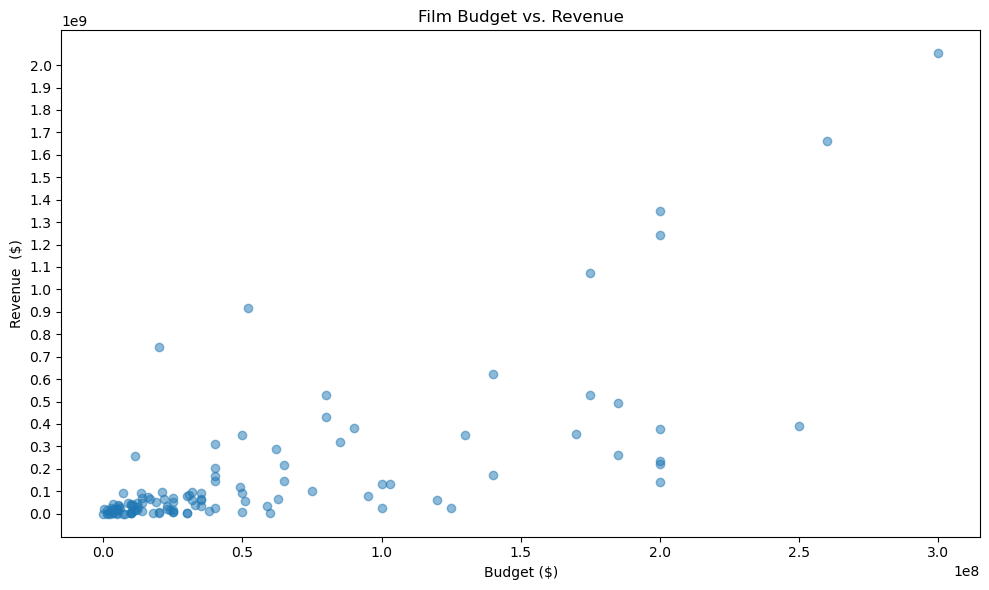

In [2]:
# Connecting to the database
conn = sqlite3.connect('movies.db')
cur = conn.cursor()

# Executing a SELECT query to fetch data from the budget and revenue columns in the movie_data table
cur.execute("SELECT budget, revenue FROM movie_data")
results = cur.fetchall()

# Encountered some strange formatting in some empty cells in the database table
# Checking for NaN values and emptry strings and discluding them
# Converting numeric values left to floats
valid_data = [(float(row[0]), float(row[1])) for row in results if row[0] is not None and row[0] != '' and row[1] is not None and row[1] != '']
# Transposing list of tuples and groups into variables budgets and revenues
budgets, revenues = zip(*valid_data)

# Plotting a scatterplot of budgets vs. revenues
plt.figure(figsize=(10, 6))
plt.scatter(budgets, revenues, alpha=0.5)
plt.xlabel('Budget ($)')
plt.ylabel('Revenue  ($)')
plt.title('Film Budget vs. Revenue')
plt.xticks(ticks=range(0, int(max(budgets)) + 1, 50000000))
plt.yticks(ticks=range(0, int(max(revenues)) + 1, 100000000))
plt.tight_layout()
plt.show()

# Closing the connection
conn.close()

There does seem to be a weak positive correlation between the budget of a film and how much revenue it brought in, so this could be a relationship I would want to explore with further analysis.

### Visualization 3: Time Before Hitting Streaming vs. Revenue

The next visualization I want to make will look at the time between a movie released in theaters and when it ends up on a streaming service. I plan to plot a scatter plot looking at this time difference for each film in relation to the film's revenue to see if there is any relationship between how quickly a film ends up on streaming and how much money it made at the boxoffice.

Because I am not too familiar with working with datetime data types by using SQL, and in this case I am going to have to calculate the difference in days between two dates, I am going to bring in one of my joined tables into a Pandas data frame so I can more easily work with these date columns.

In [4]:
# Connecting to the database
conn = sqlite3.connect('movies.db')

# Executing SQL query to retrieve data from the joined table
query = """
        SELECT *
        FROM joined_table_inner
        """

# Fetching the data and creating the data frame
joined_df = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Displaying the head of the dataframe
joined_df.head()

,show_id,type,title,director,cast,country_produced,date_added_streaming,release_year,rating,runtime,streaming_genre,description,streaming_service,rank_total,rank_calendar,title:1,release_date,closing_date,total_gross,calendar_gross,opening_gross,percent_of_total_gross,opening_theaters,max_theaters,distributor,total_contains_estimates,calendar_contains_estimates,rerelease,adult,backdrop_path,id_tmdb,original_language,original_title,overview,popularity,poster_path,release_date_tmdb,title:2,video,vote_average,vote_count,belongs_to_collection,budget,genres,homepage,imdb_id,production_companies,production_countries,revenue,runtime:1,spoken_languages,status,tagline,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science,genre_TV,genre_Thriller,genre_War,genre_Western
0,s7733,Movie,Peter Rabbit,Will Gluck,"James Corden, Domhnall Gleeson, Rose Byrne, Ma...","United States, Australia",2018-08-18,2018,PG,95,"Children & Family Movies, Comedies","In this mix of live action and CGI, rascally P...",Netflix,29,27,Peter Rabbit,2/9/2018,6/14/2018,"$115,253,424","$115,253,424","$25,010,928",21.70%,3725,3725,Sony Pictures Releasing,FALSE,FALSE,FALSE,FALSE,/1wj8H9gdtkb98Tl3zu0hrHfW0qw.jpg,381719,en,Peter Rabbit,Peter Rabbit's feud with Mr. McGregor escalate...,20.623,/lugOvdaNpbVGQK9TyMRDiUbLtY6.jpg,2/7/2018,Peter Rabbit,FALSE,6.7,1684,Peter Rabbit Collection,50000000,"Animation, Adventure, Family",http://www.peterrabbit-movie.com,tt5117670,"Columbia Pictures, Animal Logic, 2.0 Entertain...","Australia, United States of America",351266433,93,English,Released,Who said the countryside was peaceful?,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,s6326,Movie,Black Panther,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",United States,2018-09-04,2018,PG-13,135,"Action & Adventure, Sci-Fi & Fantasy","T'Challa, the superpowered new leader of the h...",Netflix,1,1,Black Panther,2/16/2018,8/9/2018,"$700,059,566","$700,059,566","$202,003,951",28.90%,4020,4084,Walt Disney Studios Motion Pictures,FALSE,FALSE,FALSE,FALSE,/b6ZJZHUdMEFECvGiDpJjlfUWela.jpg,284054,en,Black Panther,"King T'Challa returns home to the reclusive, t...",74.063,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,2/13/2018,Black Panther,FALSE,7.385,21417,Black Panther Collection,200000000,"Action, Adventure, Science Fiction",https://www.marvel.com/movies/black-panther,tt1825683,Marvel Studios,United States of America,1349926083,135,"English, 한국어/조선말, Kiswahili,",Released,Long live the king.,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,s6326,Movie,Black Panther,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",United States,2018-09-04,2018,PG-13,135,"Action & Adventure, Sci-Fi & Fantasy","T'Challa, the superpowered new leader of the h...",Netflix,121,149,Black Panther,7/10/2020,,"$367,000","$367,000","$367,000",,421,421,Walt Disney Pictures,TRUE,FALSE,TRUE,FALSE,/b6ZJZHUdMEFECvGiDpJjlfUWela.jpg,284054,en,Black Panther,"King T'Challa returns home to the reclusive, t...",74.063,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,2/13/2018,Black Panther,FALSE,7.385,21417,Black Panther Collection,200000000,"Action, Adventure, Science Fiction",https://www.marvel.com/movies/black-panther,tt1825683,Marvel Studios,United States of America,1349926083,135,"English, 한국어/조선말, Kiswahili,",Released,Long live the king.,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,s6066,Movie,A Wrinkle in Time,Ava DuVernay,"Storm Reid, Oprah Winfrey, Reese Witherspoon, ...",United States,2018-09-25,2018,PG,110,Children & Family Movies,"Years after their father disappears, Meg and h...",Netflix,33,34,A Wrinkle in Time,3/9/2018,7/5/2018,"$100,478,608","$100,478,608","$33,123,609",33%,3980,3980,Walt Disney Studios Motion Pictures,FALSE,FALSE,FALSE,FALSE,/852VpfhfHv4kjcq2uBHVUZMKFjT.jpg,407451,en,A Wrinkle in Time,After the disappearance of her scientist fathe...,16.592,/yAcb58vipewa1BfNit2RjE6boXA

When making my tables, I realize I converted all data types to text in the SQLite databes. In order to work with the dates columns, I need to change them back to datetime:

In [5]:
# Checking current type of date_added_streaming, release_date, and revenue
print(joined_df["date_added_streaming"].dtype, joined_df["release_date"].dtype, joined_df["revenue"].dtype)

object object object


In [6]:
# Dropping any empy strings or nonnumeric values from revenue and changing numeric values to integers
joined_df['revenue'] = pd.to_numeric(joined_df['revenue'], errors='coerce')
joined_df.dropna(subset=['revenue'], inplace=True)
joined_df['revenue'] = joined_df['revenue'].astype(int)

In [7]:
# Changing release_date and date_added_streaming to datetime
joined_df["release_date"] = pd.to_datetime(joined_df["release_date"])
joined_df["date_added_streaming"] = pd.to_datetime(joined_df["date_added_streaming"])

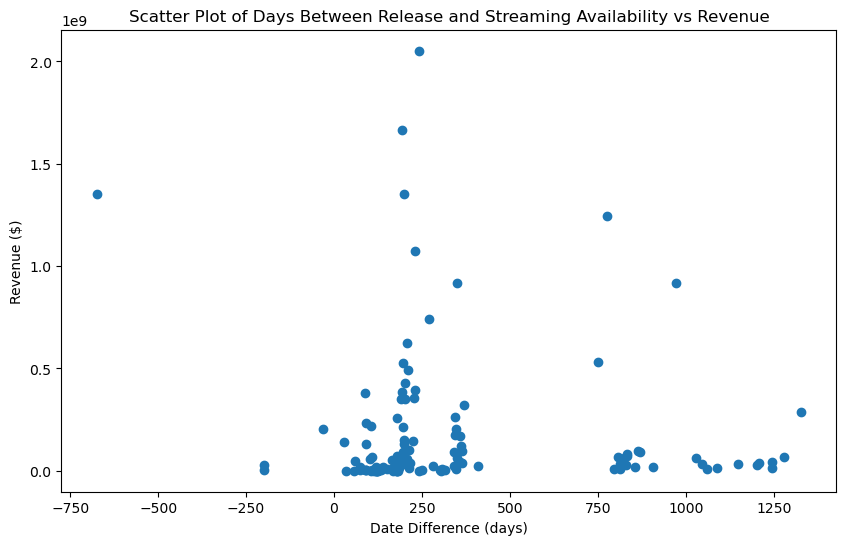

In [8]:
# Calculating the difference in days beterrn the date added to streaming and the release date
date_difference = (joined_df["date_added_streaming"] - joined_df["release_date"]).dt.days

# Plotting a scatter plot of the difference between streaming premier date and release date and film revenue
plt.figure(figsize=(10, 6))
plt.scatter(date_difference, joined_df['revenue'])
plt.xlabel('Date Difference (days)')
plt.ylabel('Revenue ($)')
plt.title('Scatter Plot of Days Between Release and Streaming Availability vs Revenue')
plt.show()

There are a few outliers here with negative days between release dates and the date added to a streaming service, so those might be worth investigating a little further. However, overall there does not seem to be an overly strong relationship between the two variables.

### Visualization 4: Box Office Total Gross by Year

The next visualization I will make will be plotting the total amount the box office grossed by year. Similar to the last visualization, I am going to bring in the boxoffice_data as a dataframe to more easilt work with data in the datetime type.

In [9]:
# Connecting to the database
conn = sqlite3.connect('movies.db')

# Executing query to retrieve data from boxoffice_data table
query = """
        SELECT *
        FROM boxoffice_data
        """

# etching data and creating data frame
boxoffice_df = pd.read_sql_query(query, conn)

# Closing the connection
conn.close()

# Displaying the head of the dataframe to check it
boxoffice_df.head()

,rank_total,rank_calendar,title,release_date,closing_date,total_gross,calendar_gross,opening_gross,percent_of_total_gross,opening_theaters,max_theaters,distributor,total_contains_estimates,calendar_contains_estimates,rerelease
0,1,1,Spider-Man: No Way Home,12/17/2021,6/30/2022,"$804,793,477","$572,984,769","$260,138,569",32.30%,4336,4336,Sony Pictures Releasing,FALSE,FALSE,FALSE
1,2,2,Shang-Chi and the Legend of the Ten Rings,9/3/2021,,"$224,543,292","$224,543,292","$75,388,688",33.60%,4300,4300,Walt Disney Studios Motion Pictures,FALSE,FALSE,FALSE
2,3,3,Venom: Let There Be Carnage,10/1/2021,1/27/2022,"$213,550,366","$212,609,036","$90,033,210",42.20%,4225,4225,Sony Pictures Releasing,FALSE,FALSE,FALSE
3,4,4,Black Widow,7/9/2021,,"$183,651,655","$183,651,655","$80,366,312",43.80%,4160,4275,Walt Disney Studios Motion Pictures,FALSE,FALSE,FALSE
4,5,5,F9: The Fast Saga,6/25/2021,,"$173,005,945","$173,005,945","$70,043,165",40.50%,4179,4203,Universal Pictures,FALSE,FALSE,FALSE


In [10]:
# Changing release_date in this data frame to datetime
boxoffice_df['release_date'] = pd.to_datetime(boxoffice_df['release_date'])

# Removing dollar sign and commas from 'total_gross' and converting to an integer
boxoffice_df['total_gross'] = boxoffice_df['total_gross'].str.replace(r'[\$,]', '', regex=True).astype(int)

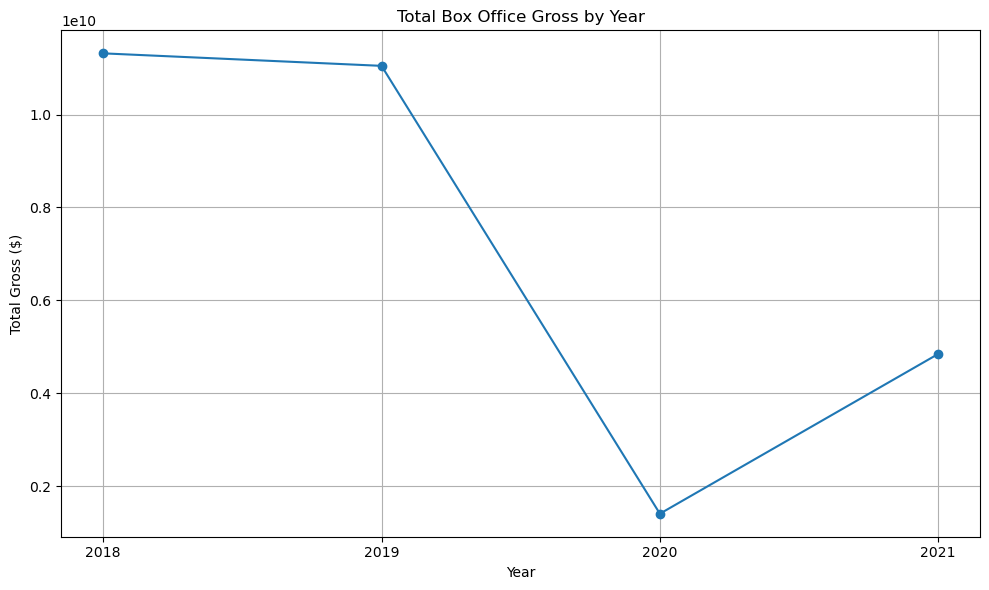

In [11]:
# Extracting the year from release_date and storing as an integer
boxoffice_df['release_year'] = boxoffice_df['release_date'].dt.year.astype(int)

# Grouingp by year and summing the total gross for each year
total_gross_by_year = boxoffice_df.groupby('release_year')['total_gross'].sum()

# Plotting Total Gross vs Year
plt.figure(figsize=(10, 6))
plt.plot(total_gross_by_year.index, total_gross_by_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Gross ($)')
plt.title('Total Box Office Gross by Year')
plt.xticks(range(int(total_gross_by_year.index.min()), int(total_gross_by_year.index.max()) + 1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

This visualization really illustrates the hit that the box offices took during the initial years of the pandemic. 

### Visualization 5: Total Film Revenue by Streaming Service

The last visualization I will make is plotting the total film revenue by streaming service. This will allow me to see what streaming services have the rights to the highest grossing films in the boxoffice, which could provide us insight about how the streaming and boxoffice industries work with one another.

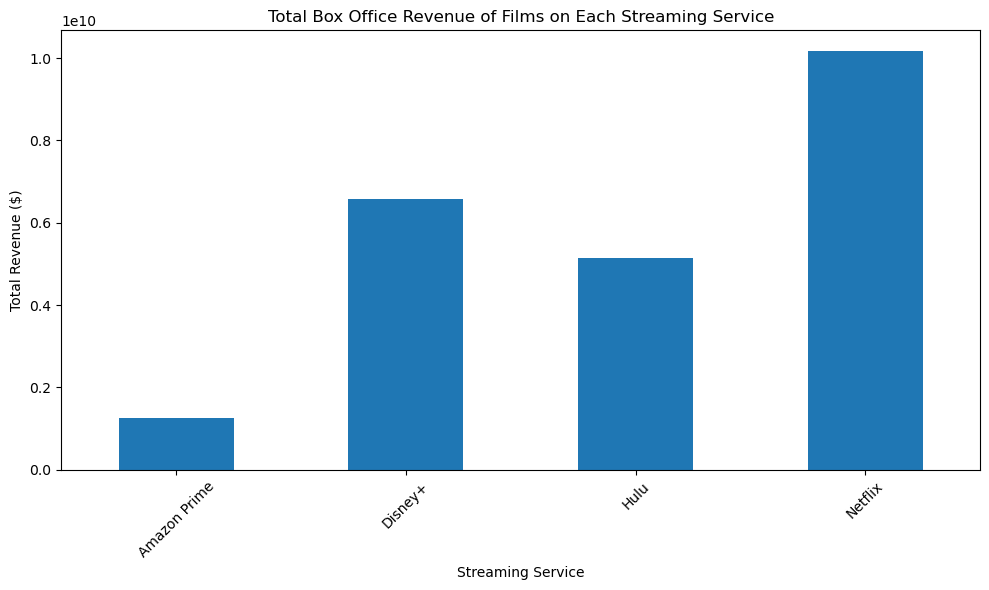

In [12]:
# Grouping the data by streaming service and calculating the sum of the revenue for each service
total_revenue_by_service = joined_df.groupby('streaming_service')['revenue'].sum()

# Plotting a bar chart of the total box office revenue of films on each streaming service
plt.figure(figsize=(10, 6))
total_revenue_by_service.plot(kind='bar')
plt.xlabel('Streaming Service')
plt.ylabel('Total Revenue ($)')
plt.title('Total Box Office Revenue of Films on Each Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It looks like Netflix has the rights to house some of the highest box office grossing films, with Disney+ following behind. Understanding the dynamics such as this between streaming services and the box office would be crucial to understanding how to measure film success in this new day an age of medai consumption.

### Conclusions, Reflections, and Ethical Implications

Prior to this course, I must say that data wrangling is something that I often took for granted. Most data sets I have worked with in the past have been relatively small, from the same type of source, and generally followed consistent pre-defined schema that I usually had control over setting prior to the data being collected. My view of what forms data could take was very narrow, but this project has really opened m eyes to just how much data exists all around us and how much work it is to make it usable – and how important this step of the process is.

For this project, we collected data from three distinct sources – a flat file, a website, and an API. Flat files I was familiar with, however pulling data from websites and APIs was a completely new concept to me. Being that the final goal of the project was to take these three data sets and join them into a single, usable, cohesive data set, I had to pay close attention as I worked with each file to ensure that I would be able to seamlessly join and work with them at the end. However, even in this last step of the project I realized just how much I didn’t take into account throughout these steps as I had to perform a few additional cleaning and transformation actions as I was constructing my visualizations. One of the biggest takeaways about data wrangling from this project for me is that data wrangling is not a linear process – in other words, there isn’t always a distinct path from start to end to follow, and it is okay if your cleansing and transformation needs change as your project changes and you need to revisit previous steps as you go. 

I have also learned a lot about being mindful and aware of the ethical implications my actions may have along the way, both with the data being used and with the actions I am performing on the data. In this project, I looked at film, box office, and streaming service data from the 2018-2021 to gain insights about how the shift in film consumption behavior (mainly due to the pandemic) may have influenced the types of films people were seeing, as well as the ways in which they were choosing to see them (streaming vs. theaters). I abided by the use guidelines of all sources I retrieved data from, and I made a point to document each step of the cleaning and transformation process I conducted on each source along the way to maintain complete transparency. As I made the finial join, I chose an inner join which only kept rows with exact title matches across each data source, and notably my web source only contained data for the top movies from each year therefore underrepresenting less popular or independently produced films. If I were to continue this project, I would attempt to find additional supplemental data to ensure representation of these types of films are accounted for in the analysis and that my final data set provides as holistic of a view into the film industry during these years as possible. I would also attempt to find additional data from streaming services to have better data to see if there is a way to measure a film’s performance on these platforms as opposed to just utilizing box-office data to infer how well they also perform on streaming.
Overall, this project was an insightful, hands-on look into the data preparation process, and I feel better equipped with the tools and knowledge to create clean and usable data sets.
